In [28]:
""" This is Phase 1 project Movie Data Exploration File started on 6 May 2023"""
""" FIVE DATASETS: 
1. SQL - MOVIE DATA, im.db
2. CSV - movie grosses, bom.movie_gross.csv
3. TSV - movie info, rt.movie_info.tsv
4. CSV - MOVIE BUDGETS, movie_budgets.csv
5. TSV - reviews, rt.reviews.tsv
6. CSV - movies, movies.csv"""

import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import os
import zlib
import zipfile
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path  
import glob
from matplotlib import font_manager


In [29]:
#This is a function to find the number of missing values per column in a dataframe
def missing_values(df_name):
    """This function iterates to find the number of missing values per column"""
    print ("Missing values by Column")
    for col in df_name.columns:
        missing = df_name[col].isna().sum()
        print (str(col) + ": " + str(missing) + " missing values")
    return

In [30]:
# This is a function to create a table of Value Counts for a particular column
def column_value_counts(df_name, col_name):
    list1 = []
    list_dict = {}
    for index, row in df_name.iterrows():
        value = row[col_name]
        if value in list1:
            list_dict[col_name] +=1
            continue
        else:
            list1.append(value)
            list_dict[col_name] = 1

    print("There are " + str(len(list1)) + " unique.")
    return

In [4]:
##These are two function I wrote when completing a LinkedIn Challenge earlier to read and write files.
def create_dict():
    """This function writes the contents to the user input file path and file name."""
    contents = {'one':1, 'two':2, 'three':3}
    print(type(contents))
    print("Please enter the destination file path and name : ") #\n<For example C:\Users\User1\myfile.txt>")
    file_name = input()
    file1 = open(file_name, "w")
    with open(file_name,'w') as file1: #This saves the file as a string in the file path
      file1.write(str(contents))
    file1.close()
    return


def retrieve_dict():
    """ This function currently opens the file and returns the text file as a string and then converts it to a dictionary. """
    print("Please enter the file path and name of the dictionary file to open:")
    file_name = input("(opening files that are not formatted as dictionaries will cause errors): ")
    file2 = open(file_name, "r")
    file2_string = file2.read()
    file2.close()
    print("This is the string read from file: " + file2_string)
    new_dict = eval(file2_string) #If this isn't a dictionary, this will throw errors.
    #print("This is the results of the eval")
    #print(type(new_dict))
    print(new_dict)
    return

In [48]:
# 1) SQL - MOVIE DATA  

# Extract SQL db from zip
# ZipFile.extractall(file_path , members=None, pwd=None)Home\MovieData\


#textFile = zipfile.ZipFile("/home/hatenotwelcome/MovieData/im.db.zip", "r")
#textFile.close()

#SQL DB includes 8 tables: principals, known-for, directors, writers, persons, movie_basics, movie_ratings, movie_akas
# principals: *movie_id, 

conn = sqlite3.Connection("/home/bringingthesparkle/FlatIron/Movie_Data/im.db")

q = """
SELECT *
FROM principals
;
"""

pd.read_sql(q, conn)

# Connection closed at bottome of file

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,None,None
1028184,tt9692684,4,nm6009913,writer,writer,None


In [52]:
q = """
SELECT movie_id, primary_title, original_title as 'Original Title', start_year as 'Start Year', runtime_minutes as 'Runtime in Minutes', genres
FROM  movie_basics
;
"""

movie_basics_df = pd.read_sql(q, conn)
#print(type(movie_basics_df))
#print(movie_basics_df.head())
print(movie_basics_df.columns)

mb_df_list = movie_basics_df['movie_id']

print(len(movie_basics_df['movie_id']))
print(len(set(mb_df_list)))

print(movie_basics_df.head(2))

# By all accounts, movie id appears to be a unique identifier


Index(['movie_id', 'primary_title', 'Original Title', 'Start Year',
       'Runtime in Minutes', 'genres'],
      dtype='object')
146144
146144
    movie_id                    primary_title   Original Title  Start Year   
0  tt0063540                        Sunghursh        Sunghursh        2013  \
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

   Runtime in Minutes              genres  
0               175.0  Action,Crime,Drama  
1               114.0     Biography,Drama  


In [53]:
q = """
SELECT *
FROM  directors
;
"""

directors_df = pd.read_sql(q, conn)
print(directors_df.head(5))

print(len(directors_df))

# for some reason in this table, movie_ID is not unique and many are true duplicates, in that they are not representing more than one director (the person_id is the same).
# I will dedupe here before merging the pandas dfs.
# The query was written in SQL but I would rather de-dupe before merging for clarity.

    movie_id  person_id
0  tt0285252  nm0899854
1  tt0462036  nm1940585
2  tt0835418  nm0151540
3  tt0835418  nm0151540
4  tt0878654  nm0089502
291174


In [54]:
# Inner joining directors on persons because I want all directors but not all persons, and I really only care about directors who have information in the table

q = """
SELECT DISTINCT movie_id, person_id, primary_name as 'Director Name', birth_year as 'Birth Year', death_year as 'Death Year', primary_profession as Professions
FROM  directors
INNER JOIN persons
USING (person_id)
;
"""

directors_df2 = pd.read_sql(q, conn)
print(directors_df2.head(5))

print(len(directors_df2)) 
# This bring the total count down to 163,535 values (before adding the persons table)

    movie_id  person_id      Director Name  Birth Year  Death Year   
0  tt0285252  nm0899854        Tony Vitale      1964.0         NaN  \
1  tt0462036  nm1940585         Bill Haley         NaN         NaN   
2  tt0835418  nm0151540  Jay Chandrasekhar      1968.0         NaN   
3  tt0878654  nm0089502        Albert Pyun      1954.0         NaN   
4  tt0878654  nm2291498          Joe Baile         NaN         NaN   

                           Professions  
0             producer,director,writer  
1             director,writer,producer  
2                director,actor,writer  
3             director,writer,producer  
4  producer,director,camera_department  
163533


In [55]:
# Doing the same with writers. Again I need all writers not all persons, but I only care about the writers with data so an inner join
q = """
SELECT DISTINCT movie_id, person_id, primary_name as 'Writer Name', birth_year as 'Birth Year', death_year as 'Death Year', primary_profession as Professions
FROM  writers
INNER JOIN persons
USING (person_id)
;
"""

writers_df = pd.read_sql(q, conn)
print(writers_df.head(15))

print(len(writers_df)) 

      movie_id   person_id          Writer Name  Birth Year  Death Year   
0    tt0285252   nm0899854          Tony Vitale      1964.0         NaN  \
1    tt0438973   nm0175726         Steve Conrad      1968.0         NaN   
2    tt0438973   nm1802864        Sean Sorensen         NaN         NaN   
3    tt0462036   nm1940585           Bill Haley         NaN         NaN   
4    tt0835418   nm0310087         Peter Gaulke         NaN         NaN   
5    tt0835418   nm0841532        Gerry Swallow         NaN         NaN   
6    tt0878654   nm0284943      Randall Fontana         NaN         NaN   
7    tt0996958   nm2286991        Tara Cardinal      1978.0         NaN   
8    tt0996958   nm2651190         Kim Pritekel      1976.0         NaN   
9    tt0999913   nm0527109            Rod Lurie      1962.0         NaN   
10   tt0999913   nm0329051  David Zelag Goodman      1930.0      2011.0   
11   tt0999913   nm0001603        Sam Peckinpah      1925.0      1984.0   
12   tt0999913   nm093068

In [56]:
#This is my spot to merge the two dfs from the sql db
sql_merge_df1 = pd.merge(movie_basics_df, directors_df2, left_on='movie_id', right_on='movie_id', how='left')
sql_merge_df2 = pd.merge(sql_merge_df1, writers_df, left_on='movie_id', right_on='movie_id', how='left')
print((sql_merge_df1.shape)) # This yields a shape of 169262x11 which means there ARE records in the movie_basics that do not have entries in the directors table.
print((sql_merge_df2.shape))
print(sql_merge_df2.head(10))

#This has multiple records with the same title, but they have different writer IDs, or other fields, not duplicates

(169261, 11)
(297361, 16)
    movie_id                    primary_title              Original Title   
0  tt0063540                        Sunghursh                   Sunghursh  \
1  tt0063540                        Sunghursh                   Sunghursh   
2  tt0063540                        Sunghursh                   Sunghursh   
3  tt0063540                        Sunghursh                   Sunghursh   
4  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
5  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
6  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
7  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
8  tt0100275         The Wandering Soap Opera       La Telenovela Errante   
9  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   Start Year  Runtime in Minutes                genres person_id_x   
0        2013               175.0    Action,Crime,Drama

In [60]:
#When I tried to merge this info on title, I got almost no results and I need to check out these titles.  Are these all Hindi titles or something?
weird_titles = sql_merge_df2['primary_title']
print ((weird_titles))
list = weird_titles.tolist()
print(list[0:500])
# A lot are foreign movies, but some seem like they were probably relatively popular US movies like "The Croods", "Ant-man", "Jurassic World", and "Gnomeo and Juliet". 
# I am going to manually confirm on a few to see if this is a cleaning issue.

0                               Sunghursh
1                               Sunghursh
2                               Sunghursh
3                               Sunghursh
4         One Day Before the Rainy Season
                       ...               
297356                             6 Gunn
297357     Chico Albuquerque - Revelações
297358     Chico Albuquerque - Revelações
297359     Chico Albuquerque - Revelações
297360     Chico Albuquerque - Revelações
Name: primary_title, Length: 297361, dtype: object
['Sunghursh', 'Sunghursh', 'Sunghursh', 'Sunghursh', 'One Day Before the Rainy Season', 'The Other Side of the Wind', 'The Other Side of the Wind', 'Sabse Bada Sukh', 'The Wandering Soap Opera', 'The Wandering Soap Opera', 'The Wandering Soap Opera', 'The Wandering Soap Opera', 'A Thin Life', 'Bigfoot', 'Joe Finds Grace', 'O Silêncio', 'O Silêncio', 'Nema aviona za Zagreb', 'Pál Adrienn', 'Pál Adrienn', 'So Much for Justice!', 'Cooper and Hemingway: The True Gen', 'Children of the G

In [12]:
# This cell is not being used since I decided to dedupe the directors table and then merge
"""
q = """"""
SELECT *
FROM  movie_basics
JOIN directors
USI
ON movie_basics.movie_id = directors.movie_id
LIMIT 20
;
"""
"""
title_genre = pd.read_sql(q, conn)
print(type(title_genre))
print(title_genre.head())

# Obvviously will need to dedupe here.  But why are they being created in the first place? I assumed that movie_id was a unique identifier but it isn't notated as key 
#on the ERD"""


"\ntitle_genre = pd.read_sql(q, conn)\nprint(type(title_genre))\nprint(title_genre.head())\n\n# Obvviously will need to dedupe here.  But why are they being created in the first place? I assumed that movie_id was a unique identifier but it isn't notated as key \n#on the ERD"

In [13]:
# Closing the SQL file connection
conn.close()

In [14]:
# 2) MOVIE GROSSES

#This is the CSV containing  movie names and their domestic grosses and foreign grosses
# In this table, title has no missing values, but not sure if all unique, adding an index might be necessary
movie_grosses = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/bom.movie_gross.csv.gz', sep=',')

print(movie_grosses.dtypes)
print(movie_grosses.tail(5))
print('\n')

missing_values(movie_grosses)


title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object
                            title      studio  domestic_gross foreign_gross   
3382                    The Quake       Magn.          6200.0           NaN  \
3383  Edward II (2018 re-release)          FM          4800.0           NaN   
3384                     El Pacto        Sony          2500.0           NaN   
3385                     The Swan  Synergetic          2400.0           NaN   
3386            An Actor Prepares       Grav.          1700.0           NaN   

      year  
3382  2018  
3383  2018  
3384  2018  
3385  2018  
3386  2018  


Missing values by Column
title: 0 missing values
studio: 5 missing values
domestic_gross: 28 missing values
foreign_gross: 1350 missing values
year: 0 missing values


In [15]:
# creating new dataframe to represent only those with domestic gross, removing rows without
movie_grosses_domestic = movie_grosses.dropna(subset=['domestic_gross'])
# The initial shape had 3387 rows and 28 less is 3359
print (len(movie_grosses_domestic))
                                        
# then split/apply/combine on studio
studios = []
studios_dict = {}




column_value_counts(movie_grosses_domestic, 'studio')

#for index, row in movie_grosses_domestic.iterrows():
#    studio = row['studio']
#    if studio in studios:
#        studios_dict[studio] +=1
#        continue
#    else:
#        studios.append(studio)
#        studios_dict[studio] = 1

#print("There are " + str(len(studios)) + " unique studios.")
#print (studios)

df = pd.DataFrame(studios_dict.items(), columns=["Studio", "Studio_Count"])
print (df.sort_values(by=['Studio_Count'], ascending = False))



3359
There are 256 unique.
Empty DataFrame
Columns: [Studio, Studio_Count]
Index: []


In [16]:
# replace NaNS with Unknowns
movie_grosses = movie_grosses.replace(np.nan, 'Unknown')

for col in movie_grosses.columns:
    assert movie_grosses[col].isna().sum() == 0

print(movie_grosses.shape)

(3387, 5)


In [17]:
#3) CSV - MOVIE INFO

# This is the CSV with movie information with columns: id, synopsis, rating, genre, director, writer, theater_date, dvd_date, currency, box_office, runtime, studio.
# ID has type int64, all others are mixed type objects and may need cleaning. 
movie_info = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/rt.movie_info.tsv', sep='\t')
print(movie_info.head(2))

#print(movie_info.dtypes)
#print(movie_info.shape) # Shape is (1560 by 12)

# Assert that 'id' is a unique record and there are no missing values
assert movie_info["id"].isna().sum() == 0

#Using missing values function to count NaNs per column
missing_values(movie_info)


   id                                           synopsis rating   
0   1  This gritty, fast-paced, and innovative police...      R  \
1   3  New York City, not-too-distant-future: Eric Pa...      R   

                                 genre          director   
0  Action and Adventure|Classics|Drama  William Friedkin  \
1    Drama|Science Fiction and Fantasy  David Cronenberg   

                         writer  theater_date      dvd_date currency   
0                Ernest Tidyman   Oct 9, 1971  Sep 25, 2001      NaN  \
1  David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   

  box_office      runtime             studio  
0        NaN  104 minutes                NaN  
1    600,000  108 minutes  Entertainment One  
Missing values by Column
id: 0 missing values
synopsis: 62 missing values
rating: 3 missing values
genre: 8 missing values
director: 199 missing values
writer: 449 missing values
theater_date: 359 missing values
dvd_date: 359 missing values
currency: 1220 mis

In [18]:
train_set = ["The sky is blue.", "My future is as bright as the sun.", "I have international level problems."]
test_set = ["The sun in the sky is bright.", "We can see the shining sun, the bright sun."]
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(train_set) # I like data science and I'd like to really go back to grad school in eng, eng mgmt
print ("Vocabulary:")
print(count_vectorizer.vocabulary_)
Vocab = list(count_vectorizer.vocabulary_)
print(Vocab)

# Vocabulary: {'blue': 0, 'sun': 1, 'bright': 2, 'sky': 3}
freq_term_matrix = count_vectorizer.transform(test_set)
print (freq_term_matrix.todense())

count_array = freq_term_matrix.toarray()
df = pd.DataFrame(data=count_array, columns=Vocab)
print(df)

from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(freq_term_matrix)
print ("IDF:")
print(tfidf.idf_)


import altair as alt
import numpy as np

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + text).properties(width = 600)

Vocabulary:
{'the': 12, 'sky': 10, 'is': 6, 'blue': 1, 'my': 8, 'future': 3, 'as': 0, 'bright': 2, 'sun': 11, 'have': 4, 'international': 5, 'level': 7, 'problems': 9}


TypeError: 'list' object is not callable

In [ ]:
# Make a heat map of most frequent words.  Might need to

#Creat a mini df (slice)
mini_df = movie_info.iloc[3:6]
# replace NaNS with Unknowns
mini_df = mini_df.replace(np.nan, 'None')

for col in mini_df.columns:
    assert mini_df[col].isna().sum() == 0

print(mini_df.shape)

#print(mini_df)
# Create a 
syns = mini_df['synopsis']
print(type(syns))
#print(syns[0])
success_set = syns
test_set = ['This is a movie about a woman who no one believed and everyone thought this was her job fast innovative complex daring bold adventure']
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(syns) # I like data science and I'd like to really go back to grad school in eng, eng mgmt
print ("Vocabulary:")
print(count_vectorizer.vocabulary_)
Vocab = list(count_vectorizer.vocabulary_)
print(Vocab)

freq_term_matrix = count_vectorizer.transform(test_set)
print (freq_term_matrix.todense())

count_array = freq_term_matrix.toarray()
df = pd.DataFrame(data=count_array, columns=Vocab)
print(df)

"""
train_set = ["The sky is blue.", "My future is bright.", "I have international level problems."]
test_set = ["The sun in the sky is bright.", "We can see the shining sun, the bright sun."]
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(train_set) # I like data science and I'd like to really go back to grad school in eng, eng mgmt
print ("Vocabulary:")
print(count_vectorizer.vocabulary_)
Vocab = list(count_vectorizer.vocabulary_)
print(Vocab)

# Vocabulary: {'blue': 0, 'sun': 1, 'bright': 2, 'sky': 3}
freq_term_matrix = count_vectorizer.transform(test_set)
print (freq_term_matrix.todense())

count_array = freq_term_matrix.toarray()
df = pd.DataFrame(data=count_array, columns=Vocab)
print(df)"""

#from sklearn.feature_extraction.text import TfidfTransformer
#tfidf = TfidfTransformer(norm="l2")
#tfidf.fit(freq_term_matrix)
#print ("IDF:")
#print(tfidf.idf_)"""

In [ ]:
# Replacing NaNs and asserting that none remain

movie_info = movie_info.replace(np.nan, 'Unknown')

for col in movie_info.columns:
    assert movie_info[col].isna().sum() == 0

In [ ]:
movie_info["genre"].value_counts().nlargest(10)
# Clearly the genre column contains more than one category 

In [ ]:
# Massage the data 

# Create a list of all genres to query on.
movie_genres = []
movie_genre_dict = {}

for index, row in movie_info.iterrows():
    massage = row['genre']
    data = massage.split("|")
    #print (data)
    for word in data:
        if word in movie_genres:
            movie_genre_dict[word] +=1
        else:
            movie_genres.append(word)
            movie_genre_dict[word] = 1

    

print("There are " + str(len(movie_genres)) + " unique genres.")
print (movie_genres)

df = pd.DataFrame(movie_genre_dict.items(), columns=["Genre", "Genre_Counts"])
print (df.sort_values(by=['Genre_Counts'], ascending = False))


In [19]:
# 4) CSV - MOVIE BUDGETS
#This is the file tn.movie_budgets.csv.gz. This is the only file with the budgets and grosses from which you can obtain the ROI.

movie_budgets = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/tn.movie_budgets.csv.gz', sep=',')
print(movie_budgets.shape)
print(movie_budgets.dtypes)
print(movie_budgets.tail(5))
print('\n')

missing_values(movie_budgets)  #

(5782, 6)
id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object
      id  release_date                          movie production_budget   
5777  78  Dec 31, 2018                         Red 11            $7,000  \
5778  79   Apr 2, 1999                      Following            $6,000   
5779  80  Jul 13, 2005  Return to the Land of Wonders            $5,000   
5780  81  Sep 29, 2015           A Plague So Pleasant            $1,400   
5781  82   Aug 5, 2005              My Date With Drew            $1,100   

     domestic_gross worldwide_gross  
5777             $0              $0  
5778        $48,482        $240,495  
5779         $1,338          $1,338  
5780             $0              $0  
5781       $181,041        $181,041  


Missing values by Column
id: 0 missing values
release_date: 0 missing values
movie: 0 missing values
production_budget: 0 missi

In [20]:
# String cleaning to turn budget and gross figures into numeric values, and compute the ROI.
movie_budgets["production_budget"] = movie_budgets["production_budget"].str.replace("$","").str.replace(",","")
movie_budgets["production_budget"] = pd.to_numeric(movie_budgets["production_budget"])
movie_budgets["domestic_gross"] = movie_budgets["domestic_gross"].str.replace("$","").str.replace(",","")
movie_budgets["domestic_gross"] = pd.to_numeric(movie_budgets["domestic_gross"])
movie_budgets["worldwide_gross"] = movie_budgets["worldwide_gross"].str.replace("$","").str.replace(",","")
movie_budgets["worldwide_gross"] = pd.to_numeric(movie_budgets["worldwide_gross"])
movie_budgets["ROI"] = ((movie_budgets["domestic_gross"] + movie_budgets["worldwide_gross"]) - movie_budgets["production_budget"])
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,876127750
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-157475300
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1531419831
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,1619903129


In [21]:
#Now that ROI has been calculated, can sort by ROI
movie_budgets.sort_values('ROI', ascending = False, inplace=True)
print(movie_budgets.head(2))


   id  release_date                                 movie  production_budget   
0   1  Dec 18, 2009                                Avatar          425000000  \
5   6  Dec 18, 2015  Star Wars Ep. VII: The Force Awakens          306000000   

   domestic_gross  worldwide_gross         ROI  
0       760507625       2776345279  3111852904  
5       936662225       2053311220  2683973445  


In [22]:
# Calculate percentiles
data = np.array(movie_budgets['ROI'])
print(len(data))
q75, q25 = np.percentile(data, [75 ,25])
iqr = q75 - q25
print (q75)
print(q25)
top_25_pct = movie_budgets[movie_budgets['ROI']> q75]
print(type(top_25_pct))
bottom_25_pct = movie_budgets[movie_budgets['ROI']< q25 ]
#iqr_range = movie_budgets.loc[[movie_budgets['ROI']> q25] & [movie_budgets['ROI']<q75]]
print(len(top_25_pct))
print(len(bottom_25_pct))
#above_35 = titanic[titanic["Age"] > 35]

5782
111164787.5
-309822.25
<class 'pandas.core.frame.DataFrame'>
1446
1446


In [23]:
top_25_pct.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2683973445
42,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682
33,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,2086125489


Text(0, 0.5, 'ROI in Billions of $')

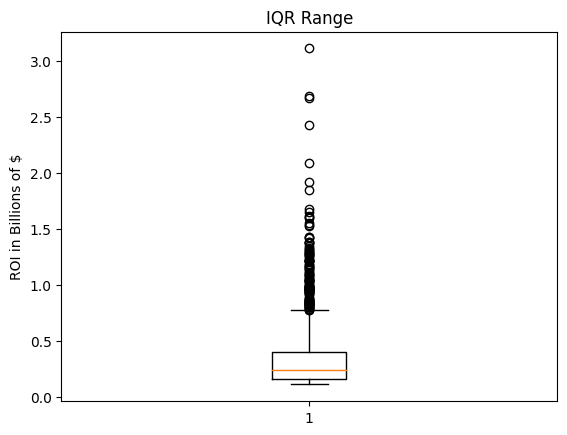

In [24]:
#boxplot of ROI (later to be updated with the by genre specs)
#matplotlib.pyplot.boxplot(movie_budgets['ROI']) 
matplotlib.pyplot.boxplot((top_25_pct['ROI'])/1000000000) # This isn't right
matplotlib.pyplot.title('IQR Range')
matplotlib.pyplot.ylabel('ROI in Billions of $')
#matplotlib.pyplot.title(label, fontdict=None, loc='center', pad=None, **kwargs)
#matplotlib.pyplot.boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None, *, data=None)

In [ ]:
# Exploration of Titles

from sklearn.feature_extraction.text import CountVectorizer

vocab_list = top_25_pct['movie']
print(type(vocab_list.to_list()))
coun_vect = CountVectorizer()
coun_vect.fit_transform(vocab_list.to_list())
print ("Vocabulary:")
print((coun_vect.vocabulary_))

"""

text = ["John is a good boy. John watches basketball"]

vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)

print(vectorizer.vocabulary_)

# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

"""

#freq_term_matrix = coun_vect.transform(vocab_list)
#print (freq_term_matrix.todense())

#"""train_set = ["The sky is blue.", "My future is bright.", "I have international level problems."]
#test_set = ["The sun in the sky is bright.", "We can see the shining sun, the bright sun."]
#count_vectorizer = CountVectorizer()
#count_vectorizer.fit_transform(train_set) # I like data science and I'd like to really go back to grad school in eng, eng mgmt
#print ("Vocabulary:")
#print(count_vectorizer.vocabulary_)
#Vocab = list(count_vectorizer.vocabulary_)
#print(Vocab)

# Vocabulary: {'blue': 0, 'sun': 1, 'bright': 2, 'sky': 3}
#freq_term_matrix = count_vectorizer.transform(test_set)
#print (freq_term_matrix.todense())

#count_array = freq_term_matrix.toarray()
#df = pd.DataFrame(data=count_array, columns=Vocab)
#print(df)

#from sklearn.feature_extraction.text import TfidfTransformer
#tfidf = TfidfTransformer(norm="l2")
#tfidf.fit(freq_term_matrix)
#print ("IDF:")
#print(tfidf.idf_)"""



In [66]:
#5) TSV - reviews, rt.reviews.tsv
# ratings is in multiple different forms and would need manipulation

movie_info = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/rt.reviews.tsv', sep='\t', encoding='latin1')
print(movie_info.head(5))

print(movie_info.dtypes)
print(movie_info.shape) # Shape is (1560 by 12)

# Assert that 'id' is a unique record and there are no missing values
assert movie_info["id"].isna().sum() == 0

#Using missing values function to count NaNs per column
missing_values(movie_info)

   id                                             review rating   fresh   
0   3  A distinctly gallows take on contemporary fina...    3/5   fresh  \
1   3  It's an allegory in search of a meaning that n...    NaN  rotten   
2   3  ... life lived in a bubble in financial dealin...    NaN   fresh   
3   3  Continuing along a line introduced in last yea...    NaN   fresh   
4   3             ... a perverse twist on neorealism...     NaN   fresh   

           critic  top_critic         publisher               date  
0      PJ Nabarro           0   Patrick Nabarro  November 10, 2018  
1  Annalee Newitz           0           io9.com       May 23, 2018  
2    Sean Axmaker           0  Stream on Demand    January 4, 2018  
3   Daniel Kasman           0              MUBI  November 16, 2017  
4             NaN           0      Cinema Scope   October 12, 2017  
id             int64
review        object
rating        object
fresh         object
critic        object
top_critic     int64
publisher

In [67]:
#6) CSV - movies, tmdb_movies.csv
import pandas as pd

movie_tmdb = pd.read_csv('/home/bringingthesparkle/FlatIron/Movie_Data/tmdb.movies.csv', sep=',')

#print(movie_tmdb.dtypes)
print(movie_tmdb.head(2))
print('\n')

# Assert that 'id' is a unique record and there are no missing values
assert movie_tmdb["id"].isna().sum() == 0
 # Drop Unnamed column which is just another index, as it seems to cause issues later with the merge, creating duplicate entries and we already have an index and unique id
movie_tmdb.drop('Unnamed: 0', axis=1, inplace=True)


   Unnamed: 0            genre_ids     id original_language   
0           0      [12, 14, 10751]  12444                en  \
1           1  [14, 12, 16, 10751]  10191                en   

                                 original_title  popularity release_date   
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19  \
1                      How to Train Your Dragon      28.734   2010-03-26   

                                          title  vote_average  vote_count  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
1                      How to Train Your Dragon           7.7        7610  




In [68]:
print(movie_tmdb.head(2))

             genre_ids     id original_language   
0      [12, 14, 10751]  12444                en  \
1  [14, 12, 16, 10751]  10191                en   

                                 original_title  popularity release_date   
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19  \
1                      How to Train Your Dragon      28.734   2010-03-26   

                                          title  vote_average  vote_count  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
1                      How to Train Your Dragon           7.7        7610  


In [69]:
missing_values(movie_tmdb)

Missing values by Column
genre_ids: 0 missing values
id: 0 missing values
original_language: 0 missing values
original_title: 0 missing values
popularity: 0 missing values
release_date: 0 missing values
title: 0 missing values
vote_average: 0 missing values
vote_count: 0 missing values


In [70]:
# TMDB API call is handled in TMDB_APICall.ipynb
# This is where I open and read the saved dict translation table from the API call
# which should be saved at "/home/bringingthesparkle/FlatIron/genre_ids.txt"
# Using retrieve_dict() functions.  Provide the file path when prompted.

file2 = open("/home/bringingthesparkle/FlatIron/genre_ids.txt", "r")
file2_string = file2.read()
file2.close()
print("This is the string read from file: " + file2_string)
file2_dict = eval(file2_string)
# using json.loads() method
result = json.loads(file2_string)

This is the string read from file: {"genres":[{"id":28,"name":"Action"},{"id":12,"name":"Adventure"},{"id":16,"name":"Animation"},{"id":35,"name":"Comedy"},{"id":80,"name":"Crime"},{"id":99,"name":"Documentary"},{"id":18,"name":"Drama"},{"id":10751,"name":"Family"},{"id":14,"name":"Fantasy"},{"id":36,"name":"History"},{"id":27,"name":"Horror"},{"id":10402,"name":"Music"},{"id":9648,"name":"Mystery"},{"id":10749,"name":"Romance"},{"id":878,"name":"Science Fiction"},{"id":10770,"name":"TV Movie"},{"id":53,"name":"Thriller"},{"id":10752,"name":"War"},{"id":37,"name":"Western"}]}


In [71]:

#print(result)
genre_list = result['genres']
#print(len(genre_list))
#print(genre_list)
# Use API generated list to create mapping to turn values into genre names
# this is what mapping looks like s.map({'cat': 'kitten', 'dog': 'puppy'})
map_dict = {}

for item in result['genres']:
    it = iter(item.values())
    first, second = next(it), next(it)
    map_dict[first] = second

print (map_dict)

#lets try the mapping out
s = pd.Series([28, 80, 17])
s.map(map_dict)

{28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}


0    Action
1     Crime
2       NaN
dtype: object

In [72]:
#movie_tmdb and genre_ids
movie_genre_ids = []
genre_id_dict = {}

for index, row in movie_tmdb.iterrows():
    massage = row['genre_ids']
    massage = massage.replace("[", "")
    massage = massage.replace("]", "")
    massage = massage.replace(" ", "")
    data = massage.split(",")
    for id in data:
        if id in movie_genre_ids:
            genre_id_dict[id] +=1
        else:
            movie_genre_ids.append(id)
            genre_id_dict[id] = 1

    

print("There are " + str(len(set(movie_genre_ids))) + " unique genre ids.")
print (movie_genre_ids)

df_id = pd.DataFrame(genre_id_dict.items(), columns=["Genre_id", "Genre_Counts"])
print (df_id.sort_values(by=['Genre_Counts'], ascending = False))

There are 20 unique genre ids.
['12', '14', '10751', '16', '28', '878', '35', '53', '27', '80', '18', '10749', '10402', '9648', '36', '37', '10770', '10752', '99', '']
   Genre_id  Genre_Counts
10       18          8303
6        35          5652
18       99          4965
7        53          4207
8        27          3683
4        28          2612
19                   2479
11    10749          2321
5       878          1762
2     10751          1565
9        80          1515
3        16          1486
0        12          1400
12    10402          1267
13     9648          1237
1        14          1139
16    10770          1084
14       36           622
17    10752           330
15       37           205


In [73]:
# check for missing values
missing_values(movie_tmdb) 

Missing values by Column
genre_ids: 0 missing values
id: 0 missing values
original_language: 0 missing values
original_title: 0 missing values
popularity: 0 missing values
release_date: 0 missing values
title: 0 missing values
vote_average: 0 missing values
vote_count: 0 missing values


In [74]:
# Attempting to inner join movie_budgets df & movie_tmbd and on movie title. 
# I know that I will have to update one of the field before the merge to get accurate result, but then I'll have to do this anyway, so... doing this part first.

title_merge_df = pd.merge(top_25_pct, movie_tmdb, left_on='movie', right_on='original_title', how='left')
print((title_merge_df.shape)) # Without cleaning the titles up, we get an inner join that yields 2316 records 
# movie_budgets original length is 5782 records, top_25_percent is 
title_merge_df.head(10)

(1549, 16)


,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,ROI,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,"[28, 12, 14, 878]",19995.0,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676.0
1,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2683973445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682,"[12, 28, 14]",299536.0,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948.0
4,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,2086125489,"[28, 12, 878, 53]",135397.0,en,Jurassic World,20.709,2015-06-12,Jurassic World,6.6,14056.0
5,27,"May 4, 2012",The Avengers,225000000,623279547,1517935897,1916215444,"[878, 28, 12]",24428.0,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673.0
6,42,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,1848317790,"[28, 16]",86841.0,en,Black Panther,2.058,2011-01-18,Black Panther,5.1,11.0
7,42,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,1848317790,"[28, 12, 14, 878]",284054.0,en,Black Panther,44.140,2018-02-16,Black Panther,7.4,12365.0
8,67,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,1681729814,"[28, 80, 53]",168259.0,en,Furious 7,20.396,2015-04-03,Furious 7,7.3,6538.0
9,44,"Jun 15, 2018",Incredibles 2,200000000,608581744,1242520711,1651102455,"[28, 12, 16, 10751]",260513.0,en,Incredibles 2,36.286,2018-06-15,Incredibles 2,7.6,6354.0


In [75]:
missing_values(title_merge_df)
#print(title_merge_df.columns)
# Because this is an outer join, there is no field that is a unique identifier, adding a new index-column, and dropping id_x and id_y
title_merge_df.drop('id_x', axis=1, inplace=True)
title_merge_df.drop('id_y', axis=1, inplace=True)
title_merge_df = title_merge_df.reset_index()
print(title_merge_df.head())


Missing values by Column
id_x: 0 missing values
release_date_x: 0 missing values
movie: 0 missing values
production_budget: 0 missing values
domestic_gross: 0 missing values
worldwide_gross: 0 missing values
ROI: 0 missing values
genre_ids: 880 missing values
id_y: 880 missing values
original_language: 880 missing values
original_title: 880 missing values
popularity: 880 missing values
release_date_y: 880 missing values
title: 880 missing values
vote_average: 880 missing values
vote_count: 880 missing values
   index release_date_x                                 movie   
0      0   Dec 18, 2009                                Avatar  \
1      1   Dec 18, 2015  Star Wars Ep. VII: The Force Awakens   
2      2   Dec 19, 1997                               Titanic   
3      3   Apr 27, 2018                Avengers: Infinity War   
4      4   Jun 12, 2015                        Jurassic World   

   production_budget  domestic_gross  worldwide_gross         ROI   
0          425000000      

In [76]:
title_merge_df['Year'] = title_merge_df['release_date_x'].str.strip().str[-4:]
title_merge_df.sort_values('ROI', ascending = False, inplace=True)
print(title_merge_df.head(3))

   index release_date_x                                 movie   
0      0   Dec 18, 2009                                Avatar  \
1      1   Dec 18, 2015  Star Wars Ep. VII: The Force Awakens   
2      2   Dec 19, 1997                               Titanic   

   production_budget  domestic_gross  worldwide_gross         ROI   
0          425000000       760507625       2776345279  3111852904  \
1          306000000       936662225       2053311220  2683973445   
2          200000000       659363944       2208208395  2667572339   

           genre_ids original_language original_title  popularity   
0  [28, 12, 14, 878]                en         Avatar      26.526  \
1                NaN               NaN            NaN         NaN   
2                NaN               NaN            NaN         NaN   

  release_date_y   title  vote_average  vote_count  Year  
0     2009-12-18  Avatar           7.4     18676.0  2009  
1            NaN     NaN           NaN         NaN  2015  
2       

In [77]:
title_merge_df.sort_values(('Year'), ascending = True, inplace=True)
print(title_merge_df.head(2))

     index release_date_x                            movie  production_budget   
466    466   Dec 21, 1937  Snow White and the Seven Dwarfs            1488000  \
224    224   Dec 15, 1939               Gone with the Wind            3900000   

     domestic_gross  worldwide_gross        ROI genre_ids original_language   
466       184925486        184925486  368362972       NaN               NaN  \
224       198680470        390525192  585305662       NaN               NaN   

    original_title  popularity release_date_y title  vote_average  vote_count   
466            NaN         NaN            NaN   NaN           NaN         NaN  \
224            NaN         NaN            NaN   NaN           NaN         NaN   

     Year  
466  1937  
224  1939  


In [78]:
#Replace nans in "original_language" with "unk" 
title_merge_df['original_language'].fillna('unk', inplace=True)
print(set(title_merge_df['original_language']))

{'en', 'unk', 'ja', 'te', 'es'}


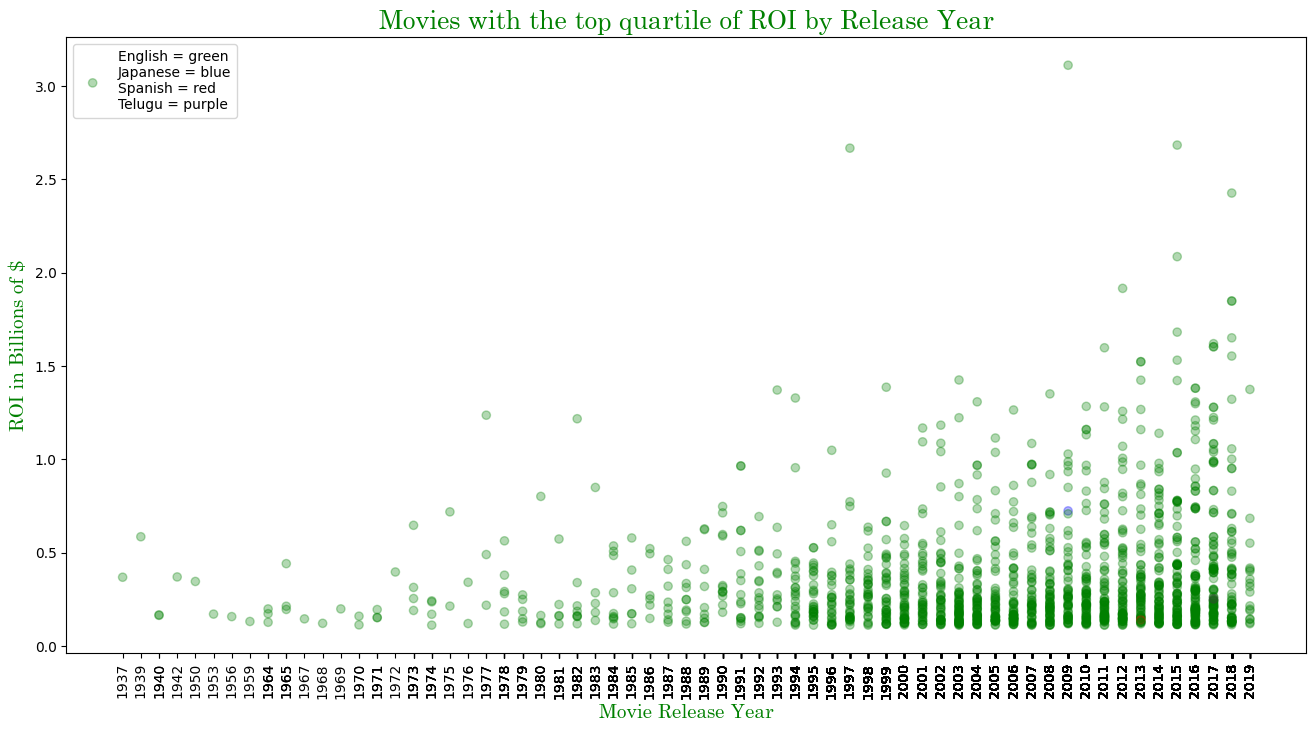

In [79]:
# Create a scatter-plot
fig, ax = plt.subplots(figsize=(16, 8))

# Instead of foreign languages, once I have mapped directors, I can use the same color schema for top directors, or studios, or whatever
colors = title_merge_df.original_language.map({'en': 'green', 'ja': 'blue', 'te': 'purple', 'es': 'red', 'unk': 'green'})
legend_text =  'English = green\nJapanese = blue\nSpanish = red\nTelugu = purple' # who knew that Telgug

font1 = {'family':'suranna','color':'green','size':20}
font2 = {'family':'suranna','color':'green','size':15}
font3 = {'family':'suranna','color':'green','size':20}

ax.scatter(
    x=title_merge_df["Year"], y=((title_merge_df["ROI"])/1000000000), alpha=0.3, c=colors, label = legend_text
)

ax.set_xticks((title_merge_df['Year']))
ax.set_xticklabels(title_merge_df['Year'], rotation = 90)
ax.set_xlabel("Movie Release Year", fontdict = font2)
ax.set_ylabel("ROI in Billions of $", fontdict = font2)
ax.set_title("Movies with the top quartile of ROI by Release Year", fontdict=font3)
ax.legend(loc="upper left");

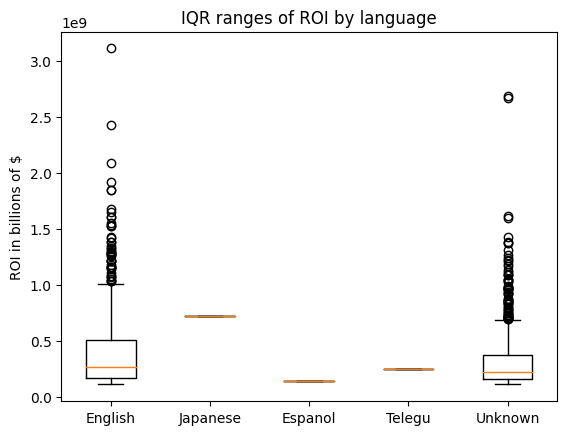

In [80]:
# Creating multiple boxplots, can change to other for

en = title_merge_df.loc[title_merge_df['original_language'] == 'en', 'ROI'].values
ja = title_merge_df.loc[title_merge_df['original_language'] == 'ja', 'ROI'].values
es =title_merge_df.loc[title_merge_df['original_language'] == 'es', 'ROI'].values
te = title_merge_df.loc[title_merge_df['original_language'] == 'te', 'ROI'].values
unk = title_merge_df.loc[title_merge_df['original_language'] == 'unk', 'ROI'].values

plt.title('IQR ranges of ROI by language')
plt.ylabel('ROI in billions of $')
plt.boxplot([en, ja, es, te, unk], labels = ['English','Japanese','Espanol','Telegu', 'Unknown' ]);



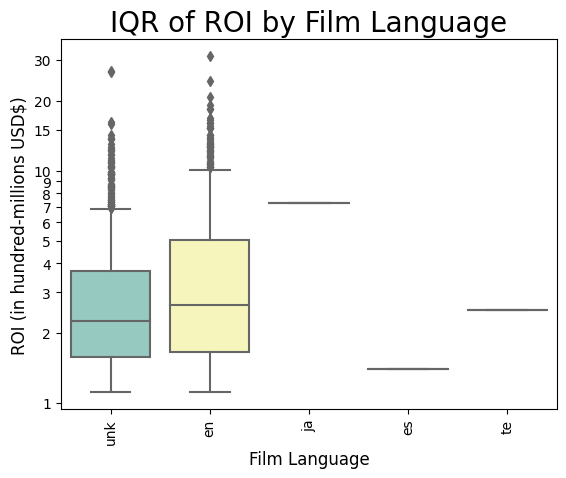

In [81]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter


sns.boxplot(x = 'original_language', y='ROI', data = title_merge_df, palette="Set3")
#print(ax.get_xticklabels)
plt.yscale('log')
plt.title('IQR of ROI by Film Language', fontsize=20)
plt.xlabel('Film Language', fontsize=12)
plt.ylabel('ROI (in hundred-millions USD$)', fontsize=12)
ytick_values = [1e8, 2e8, 3e8, 4e8, 5e8, 6e8, 7e8, 8e8, 9e8, 1e9, 1.5e9, 2e9, 3e9]
ytick_labels = []
for value in ytick_values:
    label = (str(int(value/100000000)))
    ytick_labels.append(label)
plt.yticks(ticks=ytick_values, labels=ytick_labels)
#axis.set(xticks =['en', 'ja', 'unk', 'es', 'te'], xticklabel=['E', 'J', "U", 'S', 'T'])

plt.xticks(rotation=90);


In [82]:
# prep to plot boxplots by year
title_merge_df.groupby(by='Year', dropna=True)

# Set the figure size
#plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
data = pd.DataFrame({"Box1": title_merge_df.groupby(by='Year', dropna=True)}) #, "Box2": 1})

# Plot the dataframe
#ax = data[['Box1', 'Box2']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()



ValueError: If using all scalar values, you must pass an index

In [ ]:
#Write a function that finds duplicate titles, and allows the user (me) to analyze them and drop the selected record or None
def duplicate_check(df, col1, index_col):
    names = []
    names_dict = {}
    for index, row in df.iterrows():
        name = row['movie']
        if name in names:
            names_dict[name] +=1
            #names_dict['index'].append(index)
        else:
            names.append(name)
            names_dict[name] = 1
            names_dict['index'] = df[index_col]
    print(len(names))
    for name in names:
        if names_dict[name] > 2:
            
    print(name, names_dict['index'])
    return

duplicate_check(title_merge_df, 'movies', 'index')

In [ ]:
# Group by Year and do a boxplot of years



#matplotlib.pyplot.boxplot((top_25_pct['ROI'])/1000000000)
title_merge_df[title_merge_df.Year == 2018].pyplot.scatter('Year', 'ROI')
matplotlib.pyplot.title('IQR Range', fontdict=font2)
matplotlib.pyplot.ylabel('ROI in Billions of $', fontdict = font2);



In [63]:
# New merge of SQL data on movie name and it didn't work
print(type(top_25_pct))
print(len(top_25_pct))
print(top_25_pct.columns)
print(sql_merge_df2.columns)
print(type(sql_merge_df2))
print(len(sql_merge_df2))

#Trying to change 'movie' columns from object to string so you can merge on them
top_25_pct['movie'] = top_25_pct['movie'].astype(str)
sql_merge_df2['primary_title'] = sql_merge_df2['primary_title'].astype(str)
#print(top_25_pct.dtypes)
#print(sql_merge_df2.dtypes)

roi_sql_merge_df2 = pd.merge(top_25_pct, sql_merge_df2, how='inner', left_on='movie', right_on='primary_title')
print(len(roi_sql_merge_df2))
print(top_25_pct['movie'].head())
print(sql_merge_df2['primary_title'].head())



#I don't like Titanic.  Let's not have Leo die and Rose survive...bah... 
#(297361, 16) there were 16 columns in the sql df and 7 in the $ df, but the matching is no good it seems.
#top 25 pct has 

<class 'pandas.core.frame.DataFrame'>
1446
Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'ROI'],
      dtype='object')
Index(['movie_id', 'primary_title', 'Original Title', 'Start Year',
       'Runtime in Minutes', 'genres', 'person_id_x', 'Director Name',
       'Birth Year_x', 'Death Year_x', 'Professions_x', 'person_id_y',
       'Writer Name', 'Birth Year_y', 'Death Year_y', 'Professions_y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
297361
id                    int64
release_date         object
movie                object
production_budget     int64
domestic_gross        int64
worldwide_gross       int64
ROI                   int64
dtype: object
movie_id               object
primary_title          object
Original Title         object
Start Year              int64
Runtime in Minutes    float64
genres                 object
person_id_x            object
Director Name          object
Birth Year_x          flo

/tmp/ipykernel_9707/4002330539.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_25_pct['movie'] = top_25_pct['movie'].astype(str)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,movie_id,primary_title,Original Title,...,person_id_x,Director Name,Birth Year_x,Death Year_x,Professions_x,person_id_y,Writer Name,Birth Year_y,Death Year_y,Professions_y
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,tt1775309,Avatar,Abatâ,...,nm3786927,Atsushi Wada,NaN,NaN,director,nm2179863,Yûsuke Yamada,NaN,NaN,writer
1,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,3111852904,tt1775309,Avatar,Abatâ,...,nm3786927,Atsushi Wada,NaN,NaN,director,nm4392664,Teruo Noguchi,NaN,NaN,"director,writer,editor"
2,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,tt2495766,Titanic,Titanic,...,nm4430776,Pete Meads,NaN,NaN,"actor,camera_department,miscellaneous",nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer"
3,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,tt2495766,Titanic,Titanic,...,nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer",nm5410036,Kevin Lincoln,NaN,NaN,"director,actor,writer"
4,43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2667572339,tt8852130,Titanic,Titanic,...,nm10047650,Ravi Punj,NaN,NaN,"director,writer,producer",nm10047650,Ravi Punj,NaN,NaN,"director,writer,producer"
5,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682,tt4154756,Avengers: Infinity War,Avengers: Infinity War,...,nm0751577,Anthony Russo,1970.0,NaN,"producer,director,writer",nm1321655,Christopher Markus,NaN,NaN,"writer,producer,actor"
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682,tt4154756,Avengers: Infinity War,Avengers: Infinity War,...,nm0751577,Anthony Russo,1970.0,NaN,"producer,director,writer",nm1321656,Stephen McFeely,NaN,NaN,"writer,producer,actor"
7,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682,tt4154756,Avengers: Infinity War,Avengers: Infinity War,...,nm0751577,Anthony Russo,1970.0,NaN,"producer,director,writer",nm0498278,Stan Lee,1922.0,2018.0,"producer,writer,actor"
8,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682,tt4154756,Avengers: Infinity War,Avengers: Infinity War,...,nm0751577,Anthony Russo,1970.0,NaN,"producer,director,writer",nm0456158,Jack Kirby,1917.0,1994.0,"writer,animation_department,miscellaneous"
9,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2426949682,tt4154756,Avengers: Infinity War,Avengers: Infinity War,...,nm0751577,Anthony Russo,1970.0,NaN,"producer,director,writer",nm0800209,Joe Simon,1913.0,2011.0,"writer,miscellaneous"


In [65]:
roi_sql_merge_df2.tail(20)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,movie_id,primary_title,Original Title,...,person_id_x,Director Name,Birth Year_x,Death Year_x,Professions_x,person_id_y,Writer Name,Birth Year_y,Death Year_y,Professions_y
2661,20,"Sep 22, 2017",The Lego Ninjago Movie,70000000,59281555,122737201,112018756,tt3014284,The Lego Ninjago Movie,The Lego Ninjago Movie,...,nm0517517,Bob Logan,NaN,NaN,"animation_department,art_department,writer",nm1087952,Dan Hageman,NaN,NaN,"writer,producer,miscellaneous"
2662,20,"Sep 22, 2017",The Lego Ninjago Movie,70000000,59281555,122737201,112018756,tt3014284,The Lego Ninjago Movie,The Lego Ninjago Movie,...,nm0517517,Bob Logan,NaN,NaN,"animation_department,art_department,writer",nm1156984,Kevin Hageman,NaN,NaN,"writer,producer,actor"
2663,95,"Dec 6, 1996",Daylight,80000000,32908290,158908290,111816580,tt1254978,Daylight,Daylight,...,nm0054862,David Barker,NaN,NaN,"editor,writer,editorial_department",nm0054862,David Barker,NaN,NaN,"editor,writer,editorial_department"
2664,95,"Dec 6, 1996",Daylight,80000000,32908290,158908290,111816580,tt1254978,Daylight,Daylight,...,nm0054862,David Barker,NaN,NaN,"editor,writer,editorial_department",nm0324233,Michael Godere,1976.0,NaN,"actor,writer,producer"
2665,95,"Dec 6, 1996",Daylight,80000000,32908290,158908290,111816580,tt1254978,Daylight,Daylight,...,nm0054862,David Barker,NaN,NaN,"editor,writer,editorial_department",nm0552423,Ivan Martin,NaN,NaN,"actor,writer,producer"
2666,95,"Dec 6, 1996",Daylight,80000000,32908290,158908290,111816580,tt1254978,Daylight,Daylight,...,nm0054862,David Barker,NaN,NaN,"editor,writer,editorial_department",nm1137278,Alexandra Meierhans,NaN,NaN,"actress,writer,assistant_director"
2667,95,"Dec 6, 1996",Daylight,80000000,32908290,158908290,111816580,tt2359002,Daylight,Daglicht,...,nm1082611,Diederik Van Rooijen,NaN,NaN,"director,writer,camera_department",nm1911240,Philip Delmaar,1971.0,NaN,"writer,miscellaneous"
2668,95,"Dec 6, 1996",Daylight,80000000,32908290,158908290,111816580,tt2359002,Daylight,Daglicht,...,nm1082611,Diederik Van Rooijen,NaN,NaN,"director,writer,camera_department",nm4015755,Marion Pauw,1973.0,NaN,"writer,production_manager,miscellaneous"
2669,95,"Dec 6, 1996",Daylight,80000000,32908290,158908290,111816580,tt2359002,Daylight,Daglicht,...,nm1082611,Diederik Van Rooijen,NaN,NaN,"director,writer,camera_department",nm1082611,Diederik Van Rooijen,NaN,NaN,"director,writer,camera_department"
2670,95,"Dec 6, 1996",Daylight,80000000,32908290,158908290,111816580,tt2359002,Daylight,Daglicht,...,nm1082611,Diederik Van Rooijen,NaN,NaN,"director,writer,camera_department",nm4791836,Simone Kome van Breugel,NaN,NaN,writer


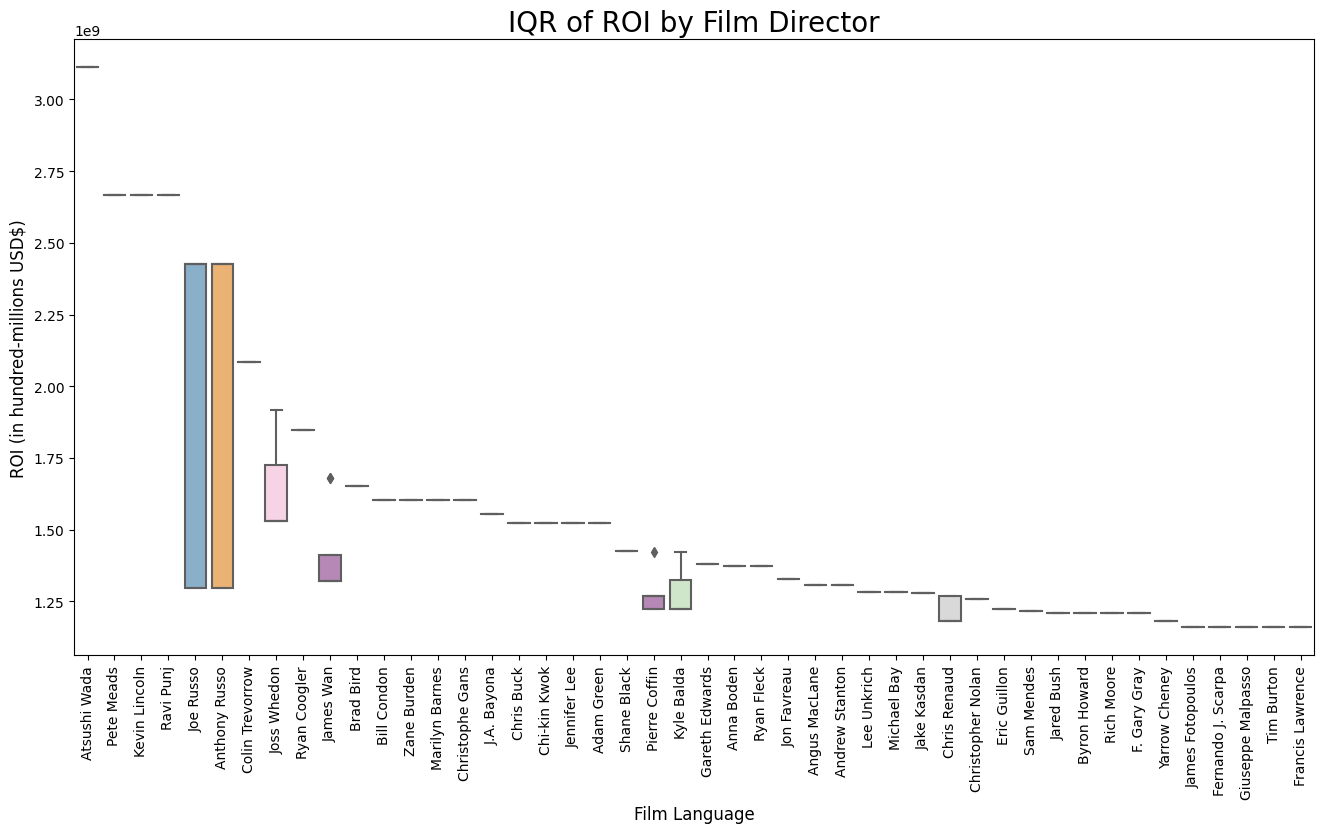

In [94]:
#This is a graph of ROI by top film director.  Because there are so many directors, I am using a slice of the sorted merged dfs with director info and the top 25% roi.
# It would be more accurate to groupby director and slice by the agreggate to truly get the top directors, not just the director of the top movies.

fig, ax = plt.subplots(figsize=(16, 8))
#Ensure the df is sorted by ROI
roi_sql_merge_df2.sort_values('ROI', ascending = False, inplace=True)
#Limit to the first 5000 records (#? top directors)
roi_sql_merge_slice = roi_sql_merge_df2[:200]

sns.boxplot(x = 'Director Name', y='ROI', data = roi_sql_merge_slice, palette="Set3")
#print(ax.get_xticklabels)
#plt.yscale('log')
plt.title('IQR of ROI by Film Director', fontsize=20)
plt.xlabel('Director', fontsize=12)
plt.ylabel('ROI (in hundred-millions USD$)', fontsize=12)
#ytick_values = [1e8, 2e8, 3e8, 4e8, 5e8, 6e8, 7e8, 8e8, 9e8, 1e9, 1.5e9, 2e9, 3e9]
#ytick_labels = []
#for value in ytick_values:
#    label = (str(int(value/100000000)))
#    ytick_labels.append(label)
#plt.yticks(ticks=ytick_values, labels=ytick_labels)
#axis.set(xticks =['en', 'ja', 'unk', 'es', 'te'], xticklabel=['E', 'J', "U", 'S', 'T'])

plt.xticks(rotation=90);


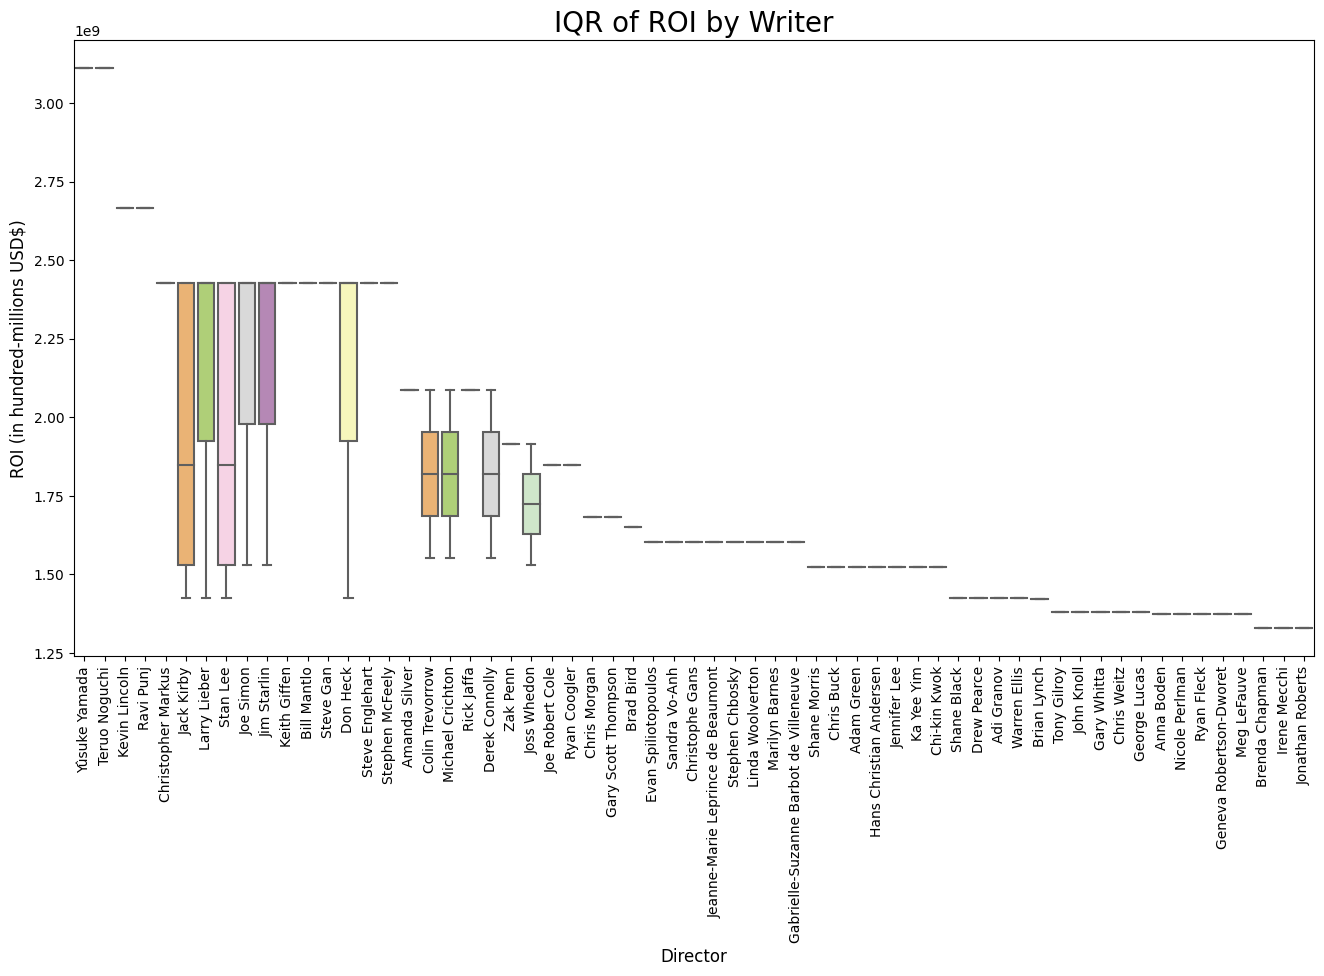

In [97]:
#This is the same idea but with writer.

fig, ax = plt.subplots(figsize=(16, 8))
#Ensure the df is sorted by ROI
roi_sql_merge_df2.sort_values('ROI', ascending = False, inplace=True)
#Limit to the first 5000 records (#? top directors)
roi_sql_merge_slice = roi_sql_merge_df2[:100]

sns.boxplot(x = 'Writer Name', y='ROI', data = roi_sql_merge_slice, palette="Set3")
#print(ax.get_xticklabels)
#plt.yscale('log')
plt.title('IQR of ROI by Writer', fontsize=20)
plt.xlabel('Writer', fontsize=12)
plt.ylabel('ROI (in hundred-millions USD$)', fontsize=12)
#ytick_values = [1e8, 2e8, 3e8, 4e8, 5e8, 6e8, 7e8, 8e8, 9e8, 1e9, 1.5e9, 2e9, 3e9]
#ytick_labels = []
#for value in ytick_values:
#    label = (str(int(value/100000000)))
#    ytick_labels.append(label)
#plt.yticks(ticks=ytick_values, labels=ytick_labels)
#axis.set(xticks =['en', 'ja', 'unk', 'es', 'te'], xticklabel=['E', 'J', "U", 'S', 'T'])

plt.xticks(rotation=90);

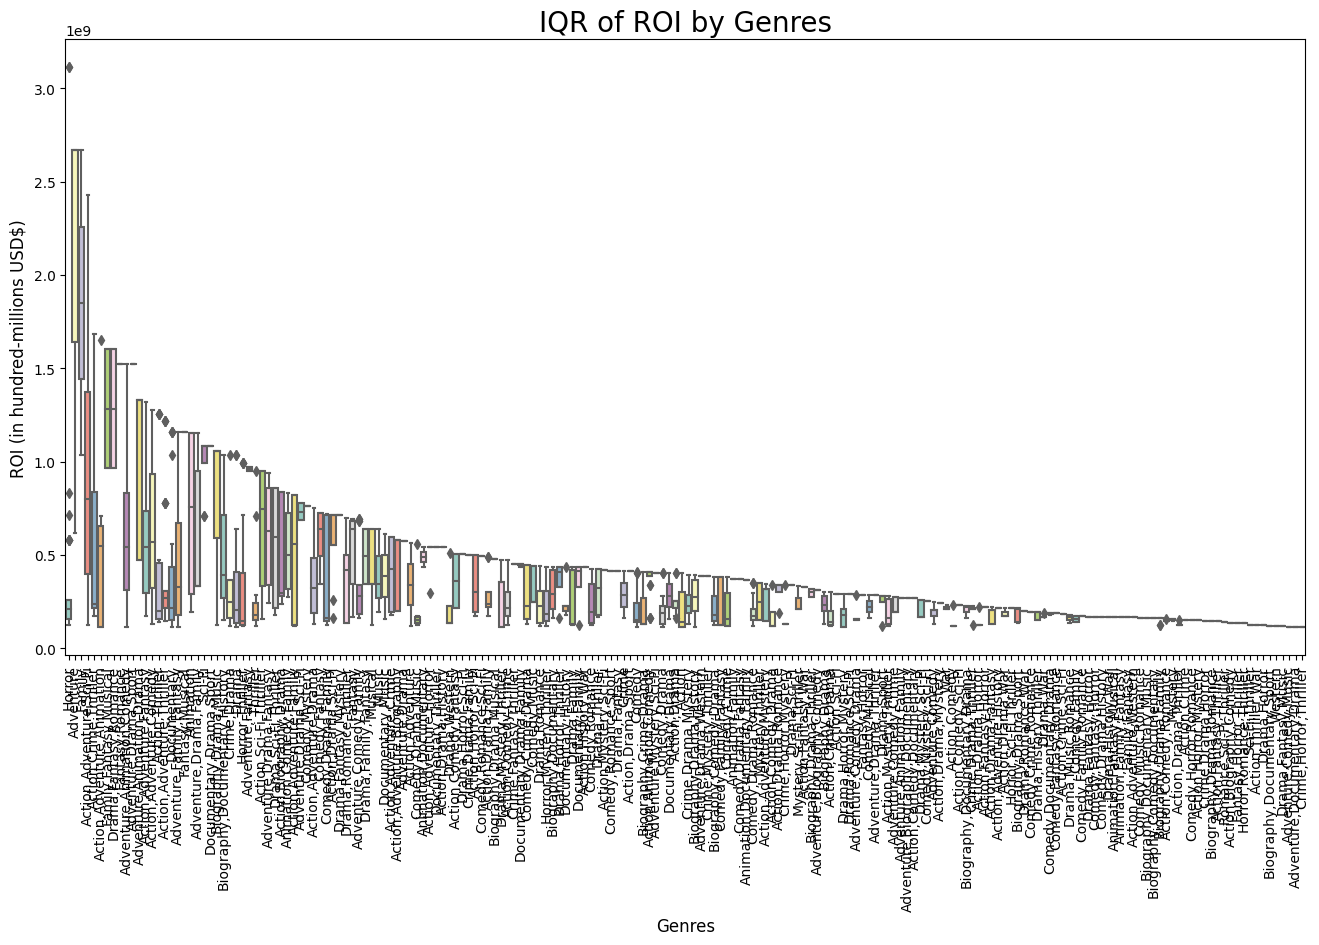

In [100]:
#This is the same idea but with genre.  Need to take care of separating genres in multiple columns.  
#Could Add a column for each of the 19 genres and give them boolean values.  Those can be used to create boxplots that can be plotted together.

fig, ax = plt.subplots(figsize=(16, 8))
#Ensure the df is sorted by ROI
roi_sql_merge_df2.sort_values('ROI', ascending = False, inplace=True)
#Limit to the first 5000 records (#? top directors)
roi_sql_merge_slice = roi_sql_merge_df2[:]

sns.boxplot(x = 'genres', y='ROI', data = roi_sql_merge_slice, palette="Set3")
#print(ax.get_xticklabels)
#plt.yscale('log')
plt.title('IQR of ROI by Genres', fontsize=20)
plt.xlabel('Genres', fontsize=12)
plt.ylabel('ROI (in hundred-millions USD$)', fontsize=12)
#ytick_values = [1e8, 2e8, 3e8, 4e8, 5e8, 6e8, 7e8, 8e8, 9e8, 1e9, 1.5e9, 2e9, 3e9]
#ytick_labels = []
#for value in ytick_values:
#    label = (str(int(value/100000000)))
#    ytick_labels.append(label)
#plt.yticks(ticks=ytick_values, labels=ytick_labels)
#axis.set(xticks =['en', 'ja', 'unk', 'es', 'te'], xticklabel=['E', 'J', "U", 'S', 'T'])

plt.xticks(rotation=90);